In [1]:
# read library

import sys
# sys.path.append('/usr/local/lib/python3.7/site-packages')
# sys.path.insert(0, '/usr/local/lib/python3.7/site-packages')
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# import pkg_resources
# pkg_resources.require("numpy==1.16.0")#15.4")
import numpy as np


# Feature Engineering

01. address ==> extract 'part' of Berlin
02. price ==> remove characters (€ , .)
03. livingSpace ==> remove (m2)
04. rooms ==> remove (Zi, redundant number)
05. tag1, tag2 ==> one-hot encoding

In [3]:
# scrapped data
df = pd.read_csv('immo_berlin_1_100_t2.csv')

## Price

In [4]:
df['price'] = df['price'].str.replace(' €', '').replace(',', '.').str.split().str[0]
df_price = df[df['price'].str.find(',')<0]
df_price['price'] = df_price['price'].str.replace('.', '').astype(float)

/Users/soyoung/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
df_price = df_price[df_price['price']>100000]

In [6]:
df = df_price.copy()

## Space

In [7]:
df['livingSpace'] = df['livingSpace'].map(lambda x: x.replace(' m²', '').replace(',', '.').split()).str[0].astype(float)


## room

In [8]:
import re
df['rooms'] = df['rooms'].str.split().str[0]
df['rooms'] = df['rooms'].map(lambda x: x.replace(',', '.'))
df['rooms'] = df['rooms'].map(lambda x: re.sub(r'[^0-9^\-\.]+', 'NaN', x).replace(',', ''))

## agency

In [9]:
df['noAgency'] = df['tag1'].str.contains('Provisionsfrei*').astype(float) +\
df['tag2'].str.contains('Provisionsfrei*').astype(float)

## balcon

In [10]:
df['balcon'] = df['tag1'].str.contains('Balkon/Terrasse').astype(float) +\
df['tag2'].str.contains('Balkon/Terrasse').astype(float)

## kitchen

In [11]:
df['kitchen'] = df['tag1'].str.contains('Einbauküche').astype(float) +\
df['tag2'].str.contains('Einbauküche').astype(float)

In [12]:
df['elevator'] = df['tag1'].str.contains('Aufzug').astype(float) +\
df['tag2'].str.contains('Aufzug').astype(float)

In [13]:
df['base'] = df['tag1'].str.contains('Keller').astype(float) +\
df['tag2'].str.contains('Keller').astype(float)

In [14]:
# remove livingSpace == 0
df = df[df['livingSpace']!=0]

In [15]:
## Drop columns

In [16]:
cols2drop = ['web-scraper-order', 'web-scraper-start-url', 'title', 'tag1', 'tag2','linkRef']
df_drop = df.drop(cols2drop, axis=1)

# Feature engineer

In [17]:
df['price/m2'] = df['price']/df['livingSpace']

In [18]:
# exclude outlier
df = df[df['price/m2']<50000] 

## Berlin price /Teil (e.g., Mitte)

In [57]:
berlin_part = ['Mitte', 'Prenzlauer Berg', 'Neukölln','Steglitz','Schöneberg','Kreuzberg','Friedrichshain',\
    'Charlottenburg','Moabit','Pankow','Gesundbrunnen','Wedding','Reinickendorf','Weißensee','Tiergarten',\
    'Wannsee','Grunewald','Tempelhof', 'Tegel','Spandau','Mariendorf','Alt-Treptow','Britz',\
    'Niederschönhausen','Johannisthal','Wilmersdorf','Nikolassee','Buchholz','Friedenau','Biesdorf',\
    'Lichterfelde','Lichtenrade','Niederschöneweide','Neu-Hohenschönhausen','Alt-Hohenschönhausen',\
    'Westend','Buckow','Alt-Treptow','Hohenschönhausen','Oberschöneweide','Plänterwald','Wittenau',\
    'Schmargendorf','Adlershof','Zehlendorf', 'Kladow','Marzahn','Köpenick','Karlshorst','Dahlem',\
    'Rummelsburg','Waidmannslust','Bohnsdorf','Altglienicke','Schmargendorf','Konradshöhe','Borsigwalde',\
    'Staaken','Friedrichsfelde','Wilhelmstadt', 'Hakenfelde','Buch','Halensee','Kaulsdorf','Lankwitz',\
    'Marienfelde','Müggelheim','Hermsdorf','Wilhelmsruh','Grünau','Friedrichshagen','Karow','Frohnau',\
    'Hansaviertel','Baumschulenweg','Gatow','Hansaviertel','Heiligensee','Mahlsdorf','Märkisches Viertel',\
    'Lübars','Siemensstadt','Falkenhagener Feld','Lichtenberg','Gropiusstadt'\
              ]   

In [58]:
import numpy as np
df['part'] = np.nan
for part in berlin_part:
    if part in (['Mitte', 'Neukölln', 'Pankow', 'Reinickendorf','Spandau']):
        add_part = '(Ortsteil)'
        df.loc[(df['address'].str.contains(part)) & (df['address'].str.contains(add_part)),'part'] = part
    else:
        add_part = ''
        df.loc[(df['address'].str.contains(part + ', Berlin')), 'part'] = part

/Users/soyoung/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [59]:
# consider only part that has enough data
top50_part = df['part'].value_counts()[:70].keys()

# EDA

## histogram

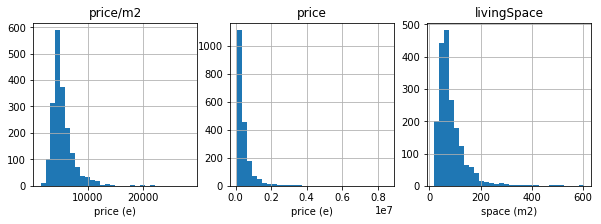

In [55]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.title('price/m2'); plt.xlabel(('price (e)'));
df['price/m2'].hist(bins=30)
plt.subplot(1,3,2); plt.title('price'); plt.xlabel('price (e)')
df['price'].hist(bins=30)
plt.subplot(1,3,3); plt.title('livingSpace'); plt.xlabel('space (m2)')
df['livingSpace'].hist(bins=30)
plt.show()

## binary features EDA

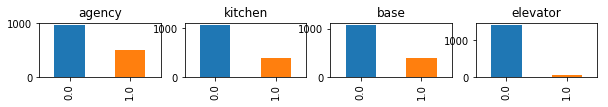

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,1))
df['noAgency'].value_counts().plot.bar(ax=axes[0], title='agency'); 
df['kitchen'].value_counts().plot.bar(ax=axes[1], title='kitchen')
df['base'].value_counts().plot.bar(ax=axes[2], title='base')
df['elevator'].value_counts().plot.bar(ax=axes[3], title='elevator')
# df.groupby('noAgency')['price'].mean().plot.bar(ax=axes[1,0])
# df.groupby('kitchen')['price'].mean().plot.bar(ax=axes[1,1])
# df.groupby('base')['price'].mean().plot.bar(ax=axes[1,2])
# df.groupby('elevator')['price'].mean().plot.bar(ax=axes[1,3])

## livingspace ~ price

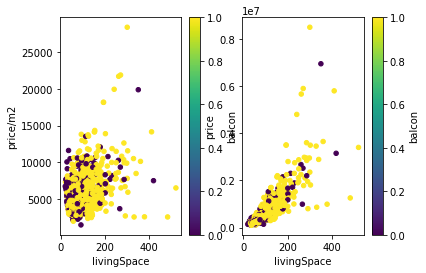

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df.plot(kind= 'scatter', x='livingSpace', y='price/m2',ax=axes[0], c='balcon',cmap='viridis')
df.plot(kind= 'scatter', x='livingSpace', y='price',ax=axes[1], c='balcon',cmap='viridis')
plt.show()

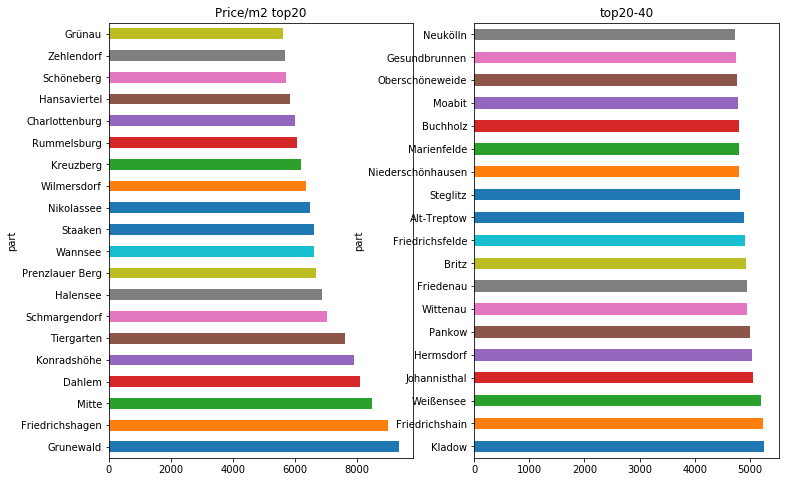

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
df.groupby('part')['price/m2'].mean().sort_values(ascending=False)[:20]\
.plot.barh(fontsize=10, ax=axes[0], title='Price/m2 top20')#figsize=(5,5), 
df.groupby('part')['price/m2'].mean().sort_values(ascending=False)[21:40]\
.plot.barh(fontsize=10, ax=axes[1], title='top20-40')#figsize=(5,5), 
#[df['part']].isin(top50_part)

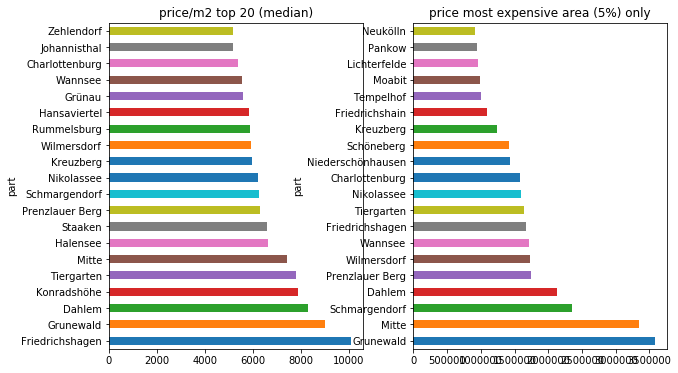

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
df.groupby('part').aggregate(lambda series: np.median(series.values)).\
sort_values(by='price/m2',ascending=False)['price/m2'][:20].\
plot.barh(ax=axes[0], title='price/m2 top 20 (median)')
df.groupby('part').aggregate(lambda series: np.median(series.quantile(0.95))).\
sort_values(by='price',ascending=False)['price'][:20].\
plot.barh(ax=axes[1], title='price most expensive area (5%) only')
#np.floor(len(series.values))])

# ML feature engineering

In [103]:
df.isna().mean()

web-scraper-order        0.000000
web-scraper-start-url    0.000000
title                    0.851603
address                  0.000000
price                    0.000000
livingSpace              0.000000
rooms                    0.000000
tag1                     0.085315
tag2                     0.240951
linkRef                  0.000000
noAgency                 0.240951
balcon                   0.240951
kitchen                  0.240951
elevator                 0.240951
base                     0.240951
price/m2                 0.000000
part                     0.001034
dtype: float64

In [105]:
df.corr()['price/m2']

price          0.733592
livingSpace    0.297712
noAgency      -0.052835
balcon         0.064761
kitchen        0.157232
elevator      -0.011422
base          -0.154063
price/m2       1.000000
Name: price/m2, dtype: float64